# Scrape the Fact Check archived page (https://www.abc.net.au/news/factcheck/browse/?nw=0) to collect all the articles url and identify which of them have a tweet as a source¶

## In the archived page, the fact check articles are categorised as follows:

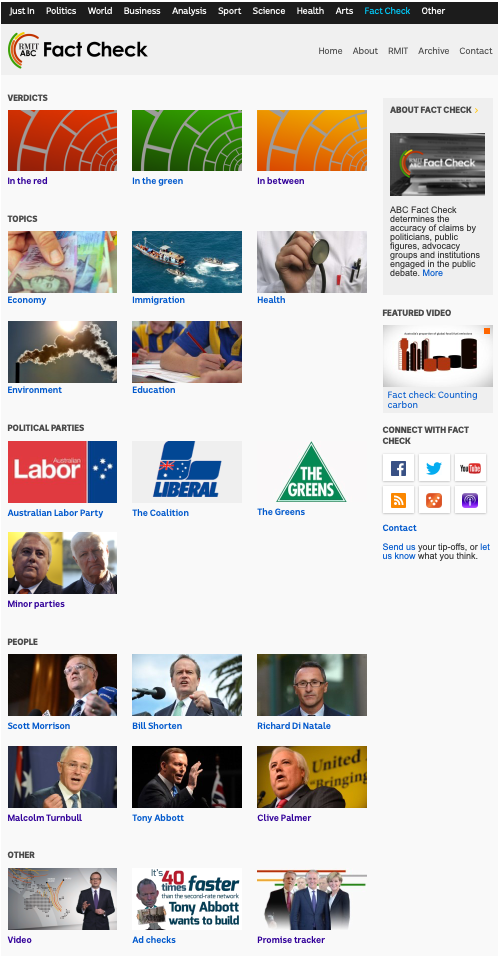

## To extract all the articles url, we do as follows:
### 1. Idenfity the categories urls
### 2. Extract the articles url from each category

In [145]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import datetime
import time
from datetime import datetime

In [155]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [156]:
def hasTweetSource(soup):
    tweet_terms = ['tweet','twitter']
    for searched_word in tweet_terms:
        results = soup.body.find_all(string=re.compile('.*{0}.*'.format(searched_word)), recursive=True)[:-1]
        if len(results) > 0:
            return True,results
    return False,""

In [147]:
## this list will contain all (i.e., from each category) the fact check url articles to scrape later when searching for a tweet source
articles_url_to_scrape = []

# this list will store the category of the article (e.g.,  in the red, economy, the greens)
articles_type = []

In [149]:
main_url = "https://www.abc.net.au/news/factcheck/browse/?nw=0"
prefix_url = "https://www.abc.net.au"
main_response = requests.get(main_url)
main_soup = BeautifulSoup(main_response.text, "html.parser")

## 1. Identify the categories' url

In [151]:
non_scrape = ['video','ad-checks','promisetracker','contact'] ## these categories are not useful for our main task
articles_type_url_to_scrape = []
all_articles_type = main_soup.find_all("article")
for article_type in all_articles_type:
    all_textlinks = article_type.find_all("div", {"class": "view-textlink"})
    for txtlink in all_textlinks:
        all_a = txtlink.find_all("a", href=True)
        for a in all_a:
            article_type_url_to_scrape = a['href']
            if article_type_url_to_scrape.split("/")[3] not in non_scrape:
                cur_article_type_url_to_scrape = prefix_url + article_type_url_to_scrape
                print(cur_article_type_url_to_scrape)
                articles_type_url_to_scrape.append(cur_article_type_url_to_scrape)

https://www.abc.net.au/news/factcheck/in-the-red/
https://www.abc.net.au/news/factcheck/in-the-green/
https://www.abc.net.au/news/factcheck/in-between/
https://www.abc.net.au/news/factcheck/economy/
https://www.abc.net.au/news/factcheck/immigration/
https://www.abc.net.au/news/factcheck/health/
https://www.abc.net.au/news/factcheck/environment/
https://www.abc.net.au/news/factcheck/education/
https://www.abc.net.au/news/factcheck/alp/
https://www.abc.net.au/news/factcheck/coalition/
https://www.abc.net.au/news/factcheck/greens/
https://www.abc.net.au/news/factcheck/minor-parties/
https://www.abc.net.au/news/factcheck/scott-morrison/
https://www.abc.net.au/news/factcheck/bill-shorten/
https://www.abc.net.au/news/factcheck/richard-di-natale/
https://www.abc.net.au/news/factcheck/malcolm-turnbull/
https://www.abc.net.au/news/factcheck/tony-abbott/
https://www.abc.net.au/news/factcheck/clive-palmer/


## 2. Extract the articles url from each category

In [153]:
for article_type_url in articles_type_url_to_scrape[:]: #iterate through each of the categories
    article_type = article_type_url.split("/")[5]
    print('article type:', article_type)
    end_reached = False #each category url may have more than one page, use this flag to identify the last page reached on each category
    next_page_url = ""
    while (not end_reached):
        print('\tpage: ', next_page_url)
        url_to_use = article_type_url + next_page_url
        article_type_response = requests.get(url_to_use)
        article_type_soup = BeautifulSoup(article_type_response.text, "html.parser")

        all_articles = article_type_soup.find_all("ul", {"class": "article-index"})
        for article in all_articles:
            all_headers = article.find_all("h3")
            for header in all_headers:
                all_a = header.find_all("a", href=True)
                for a in all_a:
                    article_url_to_scrape = prefix_url + a['href']
                    if article_url_to_scrape not in articles_url_to_scrape:
                        articles_url_to_scrape.append(article_url_to_scrape)
                        articles_type.append(article_type)
                        
        print('\tcurrent number of articles to scrape: ', len(articles_url_to_scrape))
        
        navigation_div = article_type_soup.find_all("div", {"class": "nav pagination"})
        if len(navigation_div) > 0:
            next_page_class = navigation_div[0].find_all("a", {"class": "next"})
            if len(next_page_class) > 0:
                next_page_url = next_page_class[0]['href']
            else:
                end_reached = True
        else:
            end_reached = True

article type: in-the-red
	page:  
	current number of articles to scrape:  50
	page:  ?page=2
	current number of articles to scrape:  100
	page:  ?page=3
	current number of articles to scrape:  144
article type: in-the-green
	page:  
	current number of articles to scrape:  192
	page:  ?page=2
	current number of articles to scrape:  241
	page:  ?page=3
	current number of articles to scrape:  264
article type: in-between
	page:  
	current number of articles to scrape:  312
	page:  ?page=2
	current number of articles to scrape:  362
	page:  ?page=3
	current number of articles to scrape:  410
	page:  ?page=4
	current number of articles to scrape:  458
	page:  ?page=5
	current number of articles to scrape:  498
article type: economy
	page:  
	current number of articles to scrape:  507
	page:  ?page=2
	current number of articles to scrape:  511
	page:  ?page=3
	current number of articles to scrape:  516
	page:  ?page=4
	current number of articles to scrape:  519
	page:  ?page=5
	current numbe

# At the moment we have collected all the urls from fact check articles in the archived page. Next step is to identify which of them come from a tweet source.

In [154]:
print("Total number of urls to scrape: ", len(articles_url_to_scrape))

Total number of urls to scrape:  693


## Search for tweet source information in the list of articles url to scrape

In [157]:
has_tweet_source = []
location_tweet_source = []
for article_url_to_scrape in articles_url_to_scrape:
    print(article_url_to_scrape)
    response = requests.get(article_url_to_scrape)
    soup = BeautifulSoup(response.text, "html.parser")
    state, results = hasTweetSource(soup)
    has_tweet_source.append(str(state))
    location_tweet_source.append(results)
    print('\t' + str(state))
    print(results)
    print("\n")

https://www.abc.net.au/news/2020-10-28/fact-check-queensland-unemployment-before-covid-19-coronavirus/12782678
	False



https://www.abc.net.au/news/2020-10-01/fact-check-was-victorias-lockdown-most-severe-oustide-wuhan/12690432
	False



https://www.abc.net.au/news/2020-05-21/has-hydroxychloroquine-helped-australia-flatten-the-death-curve/12256996
	False



https://www.abc.net.au/news/2020-03-12/fact-check-pauline-hanson-transgender-children-census/12044974
	False



https://www.abc.net.au/news/2020-02-13/fact-check-barista-vs-coal-mining-jobs/11958124
	False



https://www.abc.net.au/news/2019-12-05/fact-check-are-nsw-firefighters-facing--budget-cuts/11747396
	False



https://www.abc.net.au/news/2019-11-29/fact-check-is-the-cfmmeu-most-unlwaful-union-in-history/11746820
	False



https://www.abc.net.au/news/2019-11-08/fact-check-carbon-emissions-under-the-coalition/11662018
	False



https://www.abc.net.au/news/2019-09-13/did-the-coalition-inherit-an-emissions-deficit-scott-morrison

	False



https://www.abc.net.au/news/2016-03-17/fact-check-did-some-crossbenchers-get-more-votes-than-ministers/7255276
	True
['"Nearly 7,000 Qlders voted for me personally. Matt Canavan (NAT), now a minister ONLY got 325 votes. Most crossbenchers received more votes!" Senator Glenn Lazarus tweeted on February 26, 2016.', '"Muir \'got more votes than Minister Cash\'," Senator John Madigan tweeted several days later on March 1.']


https://www.abc.net.au/news/2016-02-11/fact-check-do-women-sleeping-rough-outnumber-army-soldiers/7132982
	False



https://www.abc.net.au/news/2015-12-02/fact-check-turnbull-per-capita-emissions-brazil/6968620
	False



https://www.abc.net.au/news/2015-11-18/fact-check-was-super-designed-to-get-people-off-the-pension/6923582
	False



https://www.abc.net.au/news/2015-10-30/is-nauru-virtually-a-failed-state/6869648
	False



https://www.abc.net.au/news/2015-10-28/fact-check-direct-action-vs-carbon-tax/6847234
	False



https://www.abc.net.au/news/2015-10-14/

	False



https://www.abc.net.au/news/2013-08-29/clive-palmer-wrong-asylum-seekers-pensioners/4917836
	False



https://www.abc.net.au/news/2013-08-26/clive-palmer-wrong-on-infant-mortality-rates/4912238
	False



https://www.abc.net.au/news/2013-08-23/rudd-wrong-on-abbotts-$1b-hospital-funding-cut/4906242
	False



https://www.abc.net.au/news/2013-08-23/katter-wrong-on-gun-deaths/4904576
	False



https://www.abc.net.au/news/2013-08-14/kevin-rudd-70-billion-black-hole-claim-not-credible/4871852
	False



https://www.abc.net.au/news/2013-08-14/michelle-rowland-incorrect-coalition-costings/4865274
	False



https://www.abc.net.au/news/2020-11-19/fact-check-humanities-science-graduates-uni-fee-changes/12822186
	False



https://www.abc.net.au/news/2020-08-13/fact-check-budget-debt-coronavirus-pandemic/12545628
	False



https://www.abc.net.au/news/2020-07-02/fact-check-scott-morrison-slavery-nsw-australia/12407280
	False



https://www.abc.net.au/news/2020-02-04/fact-check-facial-recogni

	False



https://www.abc.net.au/news/2014-07-27/nbn-reviews-promise-check/5546266
	False



https://www.abc.net.au/news/2014-07-27/future-of-financial-advice-reforms-promise-check/5566446
	False



https://www.abc.net.au/news/2014-07-27/sale-of-medibank-private-promise-check/5392384
	False



https://www.abc.net.au/news/2014-06-12/joe-hockey-one-billion-a-month-interest-fact-check/5478480
	False



https://www.abc.net.au/news/2014-06-04/will-the-fuel-excise-change-cost-families-only-40c-a-week/5457202
	False



https://www.abc.net.au/news/2014-05-26/is-cambodia-engulfed-in-human-rights-crisis/5446002
	False



https://www.abc.net.au/news/2014-05-20/tim-costell-correct-on-budget-foreign-aid-cuts/5452698
	False



https://www.abc.net.au/news/2014-05-08/does-australia-have-a-revenue-problem/5420474
	False



https://www.abc.net.au/news/2014-05-06/has-the-government-doubled-the-budget-deficit/5423392
	False



https://www.abc.net.au/news/2014-04-22/abolish-the-mining-tax-promise-check/534

	False



https://www.abc.net.au/news/2020-05-18/coronavirus-australia-food-security-supermarket-shelves/12244820
	False



https://www.abc.net.au/news/2020-05-08/fact-check-being-unemployed-for-a-year-reduces-chances-of-work/12211296
	False



https://www.abc.net.au/news/2020-05-06/fact-check-is-australia-getting-better-covid19-outcomes-than-nz/12215476
	False



https://www.abc.net.au/news/2020-04-23/fact-check-state-border-closures-australian-constitution-corona/12164440
	True
[" the day before Mr Downer's tweet, travellers are barred unless providing essential services under the state's ", 'In his tweet, Mr Downer referred to section 117 of the ']


https://www.abc.net.au/news/2020-03-06/fact-check-craig-kelly-rainfall-drought/12016214
	False



https://www.abc.net.au/news/2019-12-11/fact-check-how-successful-are-drug-dogs/11781344
	False



https://www.abc.net.au/news/2019-11-20/fact-check-australia-carbon-emissions-fossil-fuel-exports/11645670
	True
['recent tweet', '"The science

	False



https://www.abc.net.au/news/2018-07-13/fact-check3a-abc-greens-voters/9931782
	False



https://www.abc.net.au/news/2018-07-09/fact-check-does-million-dollars-pokies-create-three-jobs/9666538
	False



https://www.abc.net.au/news/2018-06-08/fact-check-was-the-latest-dual-citizenship-decision-clear/9808502
	False



https://www.abc.net.au/news/2018-06-06/fact-check-liberal-women-in-parliament/9796976
	False



https://www.abc.net.au/news/2018-06-01/fact-check-spending-growth-under-the-coalition/9800624
	False



https://www.abc.net.au/news/2018-05-22/fact-check3a-is-compulsory-acquisition-a-last-resort-for-extre/9718900
	False



https://www.abc.net.au/news/2018-05-17/fact-check-victoria-is-crime-up-matthew-guy/9728662
	True
['Victorian Opposition Leader Matthew Guy has tweeted that certain categories of crime have increased by more than 30 per cent since Labor was elected.', 'Premier Daniel Andrews tweeted on March 14: "Here are the facts: crime is down 10 per cent. The bigge

	False



https://www.abc.net.au/news/2015-10-23/fact-check-bill-shorten-stem-qualifications-australia/6828470
	False



https://www.abc.net.au/news/2015-10-19/fact-check-if-diabetes-was-a-country-how-big-would-it-be/6856576
	False



https://www.abc.net.au/news/2015-10-16/does-uber-need-the-laws-to-change-fact-check/6846512
	False



https://www.abc.net.au/news/2015-10-09/fact-check-women-running-big-companies/6783082
	False



https://www.abc.net.au/news/2015-10-08/suicide-rates-road-toll-john-brogden-fact-check/6822324
	False



https://www.abc.net.au/news/2015-09-18/is-bombing-in-syria-illegal-fact-check/6765386
	False



https://www.abc.net.au/news/2015-09-08/fact-check-health-star-ratings-on-foods/6518996
	False



https://www.abc.net.au/news/2015-09-04/royal-commission-crime-attack-dyson-heydon/6738284
	False



https://www.abc.net.au/news/2015-09-01/tony-abbott-emissions-reduction-targets-paris-2015/6711330
	False



https://www.abc.net.au/news/2015-08-03/whistleblowers-offshor

	False



https://www.abc.net.au/news/2014-07-27/sydney-westconnex-promise-check/5505696
	False



https://www.abc.net.au/news/2014-07-27/nbn-complete-by-2019-promise-check/5546884
	False



https://www.abc.net.au/news/2014-07-27/405-million-for-northconnex-in-sydney/5576588
	False



https://www.abc.net.au/news/2014-07-27/restore-the-private-health-insurance-rebate-promise-check/5569742
	False



https://www.abc.net.au/news/2014-07-27/bruce-highway-promise-check/5516240
	False



https://www.abc.net.au/news/2014-07-27/16m-to-factory-upgrades-at-hobart-cadbury-factory-promise-check/5447684
	False



https://www.abc.net.au/news/2014-07-27/reducing-foreign-aid-growth-promise-check/5430060
	False



https://www.abc.net.au/news/2014-07-27/18-million-centre-for-excellence-in-youth-mental-health/5454844
	False



https://www.abc.net.au/news/2014-07-27/200-million-for-dementia-research-promise-check/5454838
	False



https://www.abc.net.au/news/2014-07-27/bowel-cancer-screening-promise-check/

	False



https://www.abc.net.au/news/2017-10-19/fact-check-myanmar-aung-san-suu-kyi-kevin-rudd/9010110
	False



https://www.abc.net.au/news/2017-06-28/tony-burke-citizenship-test-university-level-english-dutton/8656754
	False



https://www.abc.net.au/news/2015-09-08/fact-file-australias-refugee-intake/6759456
	False



https://www.abc.net.au/news/2014-10-13/dreyfus-on-visas-for-islamic-preachers/5801022
	False



https://www.abc.net.au/news/2014-08-19/rights-of-surrogate-children-born-overseas/5654602
	False



https://www.abc.net.au/news/2014-07-14/fact-file-asylum-seekers-fate-in-high-court/5581926
	False



https://www.abc.net.au/news/2014-02-27/who-is-responsible-for-asylum-seekers-detained-on-manus/5275598
	False



https://www.abc.net.au/news/2013-12-10/scott-morrison-not-telling-full-story-asylum-seeker-arrivals/5119380
	False



https://www.abc.net.au/news/2013-12-03/yudhoyono-goes-too-far-on-legality-of-spying/5117318
	False



https://www.abc.net.au/news/2013-11-14/asylum-

	True
['\xa0of the Institute of Public Affairs, tweeted similar criticisms, while\xa0']


https://www.abc.net.au/news/2020-06-19/coronacheck-covid-safe-google-android-coronavirus/12367852
	False



https://www.abc.net.au/news/2020-06-13/coronacheck-mask-wearing-carbon-dioxide-covid-19/12346344
	False



https://www.abc.net.au/news/2020-06-13/coronacheck-template/12307030
	True
['While fact checkers have spent countless hours over recent years verifying and debunking US President Donald Trump’s tweets, the introduction of an official fact check warning label by Twitter appears to have been a tipping point for Mr Trump.', 'In response to having his tweets about postal voting labelled by the social media platform, Mr Trump\xa0', 'Mr Trump\xa0then went on to reference the warning label placed on his tweets, which he said was done in a matter "that clearly reflects political bias".', '"As has been reported, Twitter seems never to have placed such a label on another politician’s tweet,"\xa0h

	False



https://www.abc.net.au/news/2013-09-03/peter-dutton-elective-surgery-gp-waiting-times/4928548
	False



https://www.abc.net.au/news/2013-08-21/tony-abbott-wrong-on-vaccination-rates/4899740
	False



https://www.abc.net.au/news/2020-02-27/who-are--scientists-professionals-who-say-no-climate-emergency/11734966
	False



https://www.abc.net.au/news/2019-10-24/zombie---angus-taylor-emissions-abatement-kyoto-protocol/11630780
	False



https://www.abc.net.au/news/2019-09-30/morrison-un-speech/11553594
	False



https://www.abc.net.au/news/2019-06-18/fact-file-bradfield-scheme-drought-relief/11216616
	False



https://www.abc.net.au/news/2018-12-19/fact-check-is-the-island-nation-tuvalu-growing/10627318
	False



https://www.abc.net.au/news/2016-03-24/frydenberg-emissions-targets-zombie/7267780
	False



https://www.abc.net.au/news/2014-09-03/how-healthy-is-the-great-barrier-reef-fact-file/5649810
	False



https://www.abc.net.au/news/2013-12-22/fact-file-protecting-people-from-sh

In [158]:
## Summarise all the collected information in a csv file

df_archived_abc_factcheck_urls = pd.DataFrame(
    {'Article Type': articles_type,
     'URL': articles_url_to_scrape,
     'Has Tweet Source?': has_tweet_source,
     'Location Tweet Source' : location_tweet_source
    })

In [159]:
df_archived_abc_factcheck_urls

,Article Type,URL,Has Tweet Source?,Location Tweet Source
0,in-the-red,https://www.abc.net.au/news/2020-10-28/fact-check-queensland-unemployment-before-covid-19-coronavirus/12782678,False,
1,in-the-red,https://www.abc.net.au/news/2020-10-01/fact-check-was-victorias-lockdown-most-severe-oustide-wuhan/12690432,False,
2,in-the-red,https://www.abc.net.au/news/2020-05-21/has-hydroxychloroquine-helped-australia-flatten-the-death-curve/12256996,False,
3,in-the-red,https://www.abc.net.au/news/2020-03-12/fact-check-pauline-hanson-transgender-children-census/12044974,False,
4,in-the-red,https://www.abc.net.au/news/2020-02-13/fact-check-barista-vs-coal-mining-jobs/11958124,False,
5,in-the-red,https://www.abc.net.au/news/2019-12-05/fact-check-are-nsw-firefighters-facing--budget-cuts/11747396,False,
6,in-the-red,https://www.abc.net.au/news/2019-11-29/fact-check-is-the-cfmmeu-most-unlwaful-union-in-history/11746820,False,
7,in-the-red,https://www.abc.net.au/news/2019-11-08/fact-check-carbon-emissions-under-the-coalition/11662018,False,
8,in-the-red,https://www.abc.net.au/news/2019-09-13/did-the-coalition-inherit-an-emissions-deficit-scott-morrison/11506064,False,
9,in-the-red,https://www.abc.net.au/news/2019-09-04/fact-check-nsw-abortion-law-victoria/11474570,False,


In [160]:
now = datetime.now()
cur_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
df_archived_abc_factcheck_urls.to_csv("../../resultsv1/archived_abc_factcheck_urls_"+ cur_datetime +".csv", encoding='utf-8')